<a href="https://colab.research.google.com/github/anvibhagavathula/CNN-Kernel/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [ ]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-anvibhagavathula' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-anvibhagavathula
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [ ]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [ ]:
!pip install torchaudio

### Import code dependencies

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = 11
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 6.1 Prepare for Training



In [ ]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

Audio_processor created
Using cuda to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt	      '(QAT4bit)quant_0.pt'   tinyconv_float32_init_seed0_88.01%_0.pt
 fp32_finetune_checkpoint.pt  '(QAT8bit)quant_0.pt'
'(QAT2bit)quant_0.pt'	       quant_checkpoint.pt


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [ ]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_88.01%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

(TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ),
 TinyConv(
   (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
   (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc_reshape): Reshape(output_shape=(-1, 4000))
   (fc): Linear(in_features=4000, out_features=4, bias=True)
   (softmax): Softmax(dim=1)
 ))

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [ ]:
import torch
import torch.nn.utils.prune as prune
from src.size_estimate import count_trainable_parameters
from src.train_val_test_utils import test

def get_accuracy(model, test_loader, device):
    test_loader = data_loaders['testing']
    model.eval()
    accuracy = test(test_loader, model, device, epoch=None, loader_type='Test', verbose=False)
    return accuracy

# Specify the pruning parameters
pruning_params = [
    ("conv", "weight"),
    ("fc", "weight"),
]

total_params = count_trainable_parameters(model_fp32)
zero_params = 0
threshold = 0.05

# Apply structured pruning
for layer_name, param_name in pruning_params:
    module = dict(model_fp32.named_modules())[layer_name]
    prune.ln_structured(module, name=param_name, amount=threshold, n=2, dim=0)
    zero_params += torch.sum(module.weight == 0).item()

sparsity = zero_params / total_params

# Calculate the non-finetuned accuracy
non_finetuned_accuracy= get_accuracy(model_fp32, test_loader, "cpu")

print(model_fp32)
print(non_finetuned_accuracy)
print(sparsity)
print(total_params - zero_params)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
87.28070175438596
0.0
16652


In [ ]:
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer

def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()

            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 1
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=model_fp32, learning_rate=0.001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint.pt")
model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 1 
#total training steps: 106
{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
get_accuracy(model_fp32, test_loader, device)

74.70760233918129

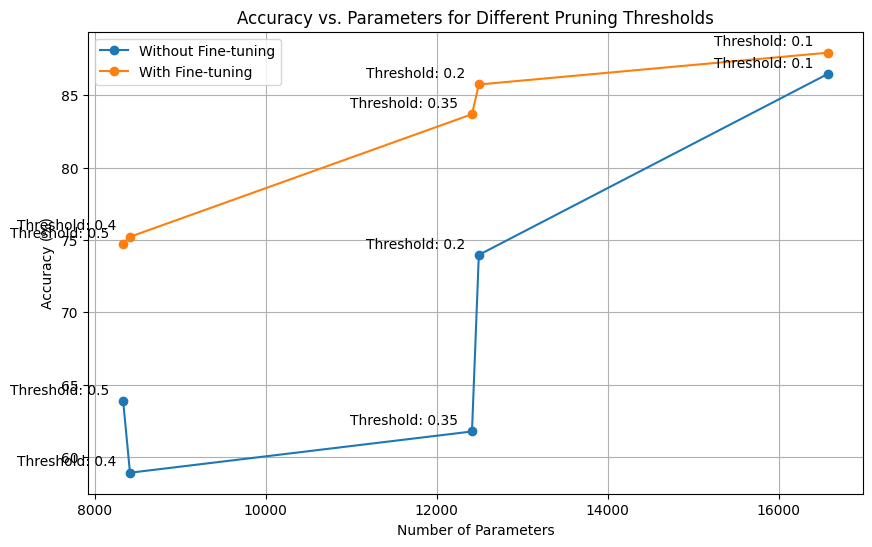

In [ ]:
thresholds = [0.1, 0.2, 0.35, 0.4, 0.5]
parameters = [16572, 12492, 12412, 8412, 8332]
acc_no_finetune = [86.47, 73.97, 61.77, 58.92, 63.88]
acc_finetune = [87.94, 85.745, 83.69, 75.22, 74.71]

# Plot accuracy vs. parameters with labels
plt.figure(figsize=(10, 6))
plt.plot(parameters, acc_no_finetune, marker='o', linestyle='-', label='Without Fine-tuning')
plt.plot(parameters, acc_finetune, marker='o', linestyle='-', label='With Fine-tuning')

for i, threshold in enumerate(thresholds):
    plt.annotate(f'Threshold: {threshold}', (parameters[i], acc_no_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')
    plt.annotate(f'Threshold: {threshold}', (parameters[i], acc_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')

plt.title('Accuracy vs. Parameters for Different Pruning Thresholds')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

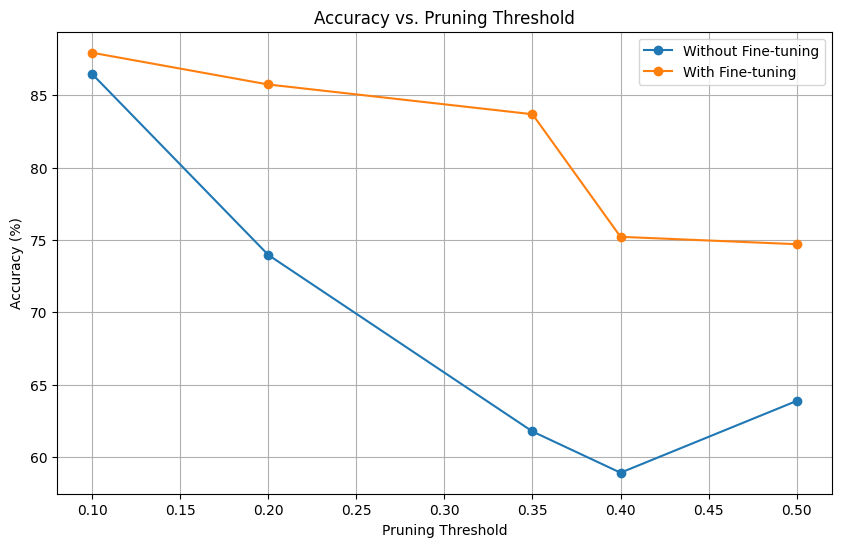

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, acc_no_finetune, marker='o', linestyle='-', label='Without Fine-tuning')
plt.plot(thresholds, acc_finetune, marker='o', linestyle='-', label='With Fine-tuning')
plt.title('Accuracy vs. Pruning Threshold')
plt.xlabel('Pruning Threshold')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Accuracy vs. FLOPs. Note that you need to elliminate the pruned channel from the model to compute FLOPS correctly and to perform the following two measurements.
Accuracy vs. runtime on desktop CPU.

In [ ]:
from src.quant_conversion import compare_model, compare_model_mse
from src.size_estimate import flop

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import copy
from src.networks import Reshape

def output_size(input_size, kernel_size, stride, padding):
    output_size = ((input_size + 2 * padding - kernel_size) // stride) + 1
    return output_size

def pruned_models(model):
    pruned_models = []

    for threshold in [0.1, 0.2, 0.35, 0.4, 0.5]:
        pruned_model = copy.deepcopy(model)

        # Conv layer
        for name, module in pruned_model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                pruning_method = prune.LnStructured(amount=threshold, n=2, dim=0)
                pruning_method.apply(module, name='weight',amount=threshold, n=2, dim=0)
                prune.remove(module, 'weight')

        conv_keep_idx = []
        for idx, tensor in enumerate(pruned_model.state_dict()['conv.weight']):
          if tensor.abs().sum().bool().item():
            conv_keep_idx.append(idx)

        # instantiate the new input for the pruned model
        kernel_size = pruned_model.conv.kernel_size
        stride = pruned_model.conv.stride
        pad = pruned_model.conv.padding
        height = output_size(49, kernel_size[0], stride[0], pad[0])
        width = output_size(40, kernel_size[1], stride[1], pad[1])

        # which weights/channels to keep
        keep_indices = torch.zeros(1, pruned_model.conv.out_channels, height, width)
        keep_indices[:, conv_keep_idx, ...] = 1.
        keep_indices = keep_indices.reshape(-1, 4000).bool()
        weight = pruned_model.conv.weight
        weight = weight[conv_keep_idx, ...]

        new_conv = nn.Conv2d(in_channels=weight.shape[1], out_channels=weight.shape[0],
                             kernel_size=kernel_size, padding=pad, stride=stride)

        with torch.no_grad():
          new_conv.weight.data = pruned_model.conv.weight.data[conv_keep_idx, :, :, :]
          new_conv.bias.data = pruned_model.conv.bias.data[conv_keep_idx]

        pruned_model.conv = new_conv

        # Linear Layer
        new_lin_weight = pruned_model.fc.weight[keep_indices.repeat((4, 1))].reshape(4, -1)
        pruned_model.fc_reshape = Reshape([-1, new_lin_weight.shape[-1]])
        new_fc = nn.Linear(new_lin_weight.shape[-1], pruned_model.fc.out_features)
        new_fc.weight = nn.Parameter(new_lin_weight)
        new_fc.bias = nn.Parameter(pruned_model.fc.bias)
        pruned_model.fc = new_fc

        pruned_models.append(pruned_model)

    return pruned_models


pruned_models = pruned_models(model_fp32_orig)
input_tensor = torch.randn((1, model_fp32_orig.model_settings['fingerprint_width'], model_fp32_orig.model_settings['spectrogram_length']))

# Get original MACs
flops = flop(model_fp32_orig, input_tensor.shape, "cpu")
print("Model 0", flops)

# Get accuracy and flops for each pruning threshold
for i, model in enumerate(pruned_models):
  print("Model:", i+1)
  flops = flop(model, input_tensor.shape, "cpu")
  print(flops)

Model 0 {'conv_reshape': {}, 'conv': {'conv2d': 2640400}, 'relu': {}, 'dropout': {}, 'fc_reshape': {}, 'fc': {'linear_weight': 32004}, '': {}}
Model: 1
{'conv_reshape': {}, 'conv': {'conv2d': 2310350}, 'relu': {}, 'dropout': {}, 'fc_reshape': {}, 'fc': {'linear_weight': 28004}, '': {}}
Model: 2
{'conv_reshape': {}, 'conv': {'conv2d': 1980300}, 'relu': {}, 'dropout': {}, 'fc_reshape': {}, 'fc': {'linear_weight': 24004}, '': {}}
Model: 3
{'conv_reshape': {}, 'conv': {'conv2d': 1650250}, 'relu': {}, 'dropout': {}, 'fc_reshape': {}, 'fc': {'linear_weight': 20004}, '': {}}
Model: 4
{'conv_reshape': {}, 'conv': {'conv2d': 1650250}, 'relu': {}, 'dropout': {}, 'fc_reshape': {}, 'fc': {'linear_weight': 20004}, '': {}}
Model: 5
{'conv_reshape': {}, 'conv': {'conv2d': 1320200}, 'relu': {}, 'dropout': {}, 'fc_reshape': {}, 'fc': {'linear_weight': 16004}, '': {}}


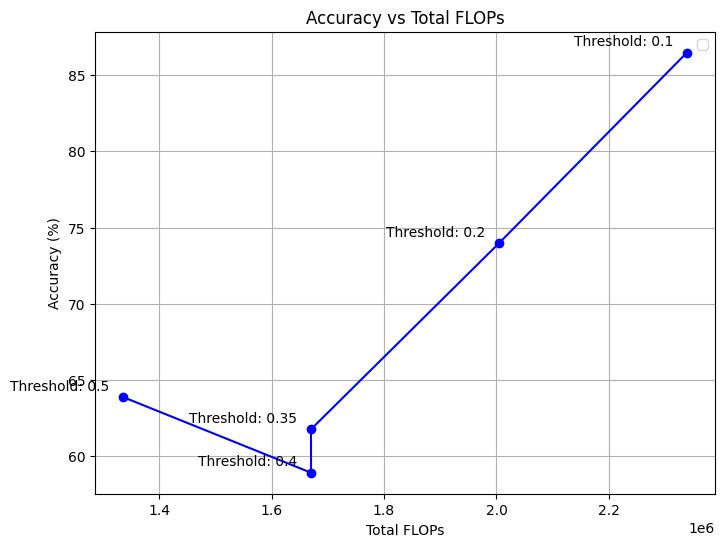

In [ ]:
import matplotlib.pyplot as plt
thresholds = [0.1, 0.2, 0.35, 0.4, 0.5]
acc_no_finetune = [86.47, 73.97, 61.77, 58.92, 63.88]
conv_flops = [2310350, 1980300, 1650250, 1650250, 1320200]
linear_flops = [28004, 24004, 20004, 20004, 16004]
total_flops = [conv + linear for conv, linear in zip(conv_flops, linear_flops)]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(total_flops, acc_no_finetune, color='blue', marker='o', linestyle='-')

for i, threshold in enumerate(thresholds):
    plt.annotate(f'Threshold: {threshold}', (total_flops[i], acc_no_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')

plt.title('Accuracy vs Total FLOPs')
plt.xlabel('Total FLOPs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import time
from src.train_val_test_utils import test

def get_accuracy(model, test_loader, device):
    test_loader = data_loaders['testing']
    model.eval()
    accuracy = test(test_loader, model, device, epoch=None, loader_type='Test', verbose=False)
    return accuracy

def pruned_runtimes(pruned_models, model_fp32, test_loader, device):
    pruned_model_runtimes = []

    for model in pruned_models:
        start = time.time()
        # Assuming get_accuracy function returns accuracy, but you need to define it if not already done.
        _ = get_accuracy(model, test_loader, device)
        end = time.time()
        runtime = end - start
        pruned_model_runtimes.append(runtime)

    return pruned_model_runtimes

pruned_runtimes = pruned_runtimes(pruned_models, model_fp32_orig, test_loader, "cpu")

In [ ]:
pruned_runtimes

[9.156306505203247,
 9.257274389266968,
 8.132311820983887,
 8.518672466278076,
 8.423567533493042]

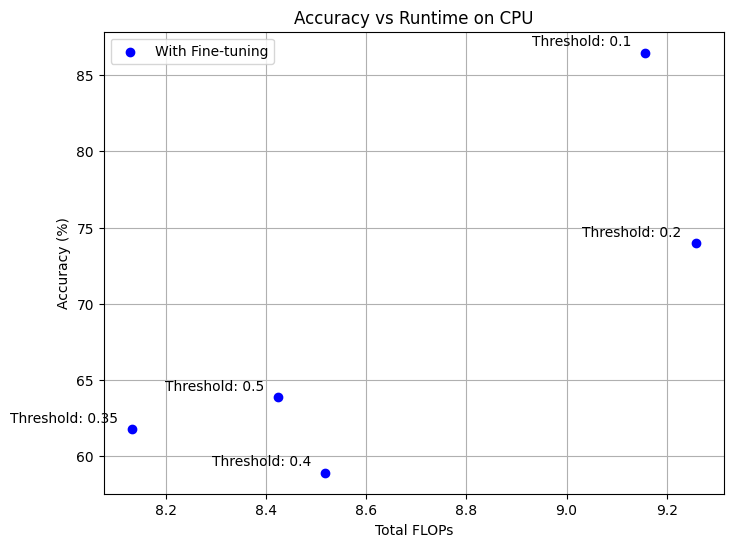

In [ ]:
acc_no_finetune = [86.47, 73.97, 61.77, 58.92, 63.88]
thresholds = [0.1, 0.2, 0.35, 0.4, 0.5]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pruned_runtimes, acc_no_finetune, color='blue', marker='o', linestyle='-', label='With Fine-tuning')

for i, threshold in enumerate(thresholds):
    plt.annotate(f'Threshold: {threshold}', (pruned_runtimes[i], acc_no_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')

plt.title('Accuracy vs Runtime on CPU')
plt.xlabel('Total FLOPs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Install ONNX
!pip3 install onnx

# Install tensorflow-addons
!pip3 install tensorflow-addons
!pip3 install tensorflow-probability

# Install onnx-tensorflow
!git clone https://github.com/onnx/onnx-tensorflow.git
!cd onnx-tensorflow && pip3 install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00
fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.
Obtaining file:///content/gdrive/MyDrive/ece5545/onnx-tensorflow
  Preparing metadata (setup.py) ... done
  Running setup.py develop for onnx-tf


In [ ]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare
import numpy as np
from src.train_val_test_utils import choose_name

# Convert the models to run on the MCU
file_name = choose_name("prune1")

# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

# Export model as .onnx file
torch.onnx.export(pruned_models[0].cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model)

# Export model as .pb file
tf_rep.export_graph(TF_PATH)

FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)

print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Pruned model is %d bytes" % tflite_model_size)

The model's will be stored as: 
 prune1_0
Float model is 60964 bytes
Pruned model is 17888 bytes


In [ ]:
!apt-get update && apt-get -qq install xxd

# Replace me!
MODEL_TFLITE = TFLITE_DIR + '/prune_prune1_0.tflite'
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!cat {MODEL_TFLITE_MICRO}

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x0

In [ ]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare
import numpy as np
from src.train_val_test_utils import choose_name

# Convert the models to run on the MCU
file_name = choose_name("prune2")

# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

# Export model as .onnx file
torch.onnx.export(pruned_models[1].cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model)

# Export model as .pb file
tf_rep.export_graph(TF_PATH)

FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)

print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Pruned model is %d bytes" % tflite_model_size)

The model's will be stored as: 
 prune2_0
Float model is 52640 bytes
Pruned model is 15784 bytes


In [ ]:
!apt-get update && apt-get -qq install xxd

# Replace me!
MODEL_TFLITE = TFLITE_DIR + '/prune_prune2_0.tflite'
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!cat {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x0

In [ ]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare
import numpy as np
from src.train_val_test_utils import choose_name

# Convert the models to run on the MCU
file_name = choose_name("prune3")

# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

# Export model as .onnx file
torch.onnx.export(pruned_models[2].cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model)

# Export model as .pb file
tf_rep.export_graph(TF_PATH)

FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)

print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Pruned model is %d bytes" % tflite_model_size)

The model's will be stored as: 
 prune3_0
Float model is 44316 bytes
Pruned model is 13672 bytes


In [ ]:
!apt-get update && apt-get -qq install xxd

# Replace me!
MODEL_TFLITE = TFLITE_DIR + '/prune_prune3_0.tflite'
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!cat {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x0

In [ ]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare
import numpy as np
from src.train_val_test_utils import choose_name

# Convert the models to run on the MCU
file_name = choose_name("prune4")

# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

# Export model as .onnx file
torch.onnx.export(pruned_models[3].cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model)

# Export model as .pb file
tf_rep.export_graph(TF_PATH)

FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)

print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Pruned model is %d bytes" % tflite_model_size)

The model's will be stored as: 
 prune4_0
Float model is 44316 bytes
Pruned model is 13672 bytes


In [ ]:
!apt-get update && apt-get -qq install xxd

# Replace me!
MODEL_TFLITE = TFLITE_DIR + '/prune_prune4_0.tflite'
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!cat {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x0

In [ ]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare
import numpy as np
from src.train_val_test_utils import choose_name

# Convert the models to run on the MCU
file_name = choose_name("prune5")

# Create a new TinyConv model
ONNX_PATH = os.path.join(ONNX_DIR, f'{file_name}.onnx')
TF_PATH = os.path.join(TF_DIR, f'{file_name}')

# Create a random input for model export
dummy_input = torch.autograd.Variable(torch.randn(1, 1960))

# Export model as .onnx file
torch.onnx.export(pruned_models[4].cpu(), dummy_input, ONNX_PATH, input_names=['in'], output_names=['out'])

# Load onnx model into a tensorflow model
onnx_model = onnx.load(ONNX_PATH)
tf_rep = prepare(onnx_model)

# Export model as .pb file
tf_rep.export_graph(TF_PATH)

FLOAT_MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
MODEL_TFLITE = os.path.join(TFLITE_DIR, f'prune_{file_name}.tflite')
float_converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
float_tflite_model = float_converter.convert()
float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)

print("Float model is %d bytes" % float_tflite_model_size)

converter = tf.lite.TFLiteConverter.from_saved_model(TF_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_dataset_gen():
    for i in range(100):
        data, _ = audio_processor.get_data(
            1, i*1, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE, TIME_SHIFT_MS, 'testing')
        flattened_data = np.array(data.flatten(), dtype=np.float32).reshape([1, 1960])
        yield [flattened_data]

converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
print("Pruned model is %d bytes" % tflite_model_size)

The model's will be stored as: 
 prune5_0
Float model is 35992 bytes
Pruned model is 11568 bytes


In [ ]:
!apt-get update && apt-get -qq install xxd

# Replace me!
MODEL_TFLITE = TFLITE_DIR + '/prune_prune5_0.tflite'
MODEL_TFLITE_MICRO = MICRO_DIR+'/micro_models.cc'

!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')

!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

!cat {MODEL_TFLITE_MICRO}

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x0

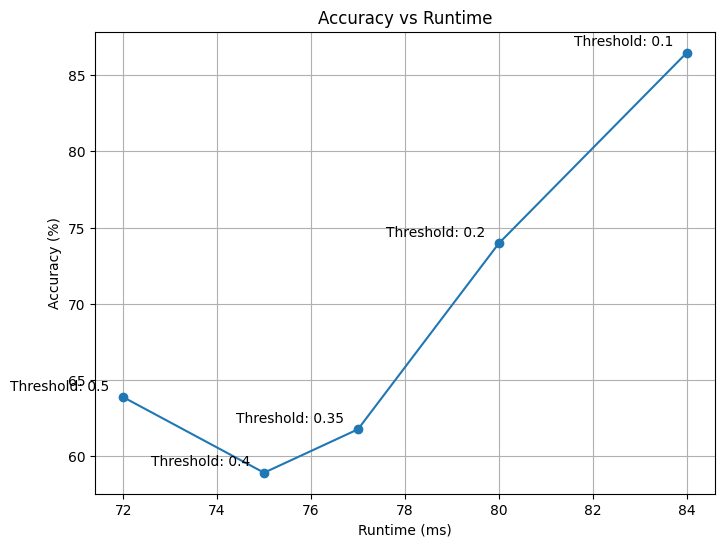

In [2]:
import matplotlib.pyplot as plt

pruned_mcu_runtimes = [84, 80, 77, 75, 72]
acc_no_finetune = [86.47, 73.97, 61.77, 58.92, 63.88]
thresholds = [0.1, 0.2, 0.35, 0.4, 0.5]

plt.figure(figsize=(8, 6))
plt.plot(pruned_mcu_runtimes, acc_no_finetune, marker='o', linestyle='-')

for i, threshold in enumerate(thresholds):
    plt.annotate(f'Threshold: {threshold}', (pruned_mcu_runtimes[i], acc_no_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')

plt.title('Accuracy vs Runtime')
plt.xlabel('Runtime (ms)')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [ ]:
import torch
import torch.nn.utils.prune as prune
from src.size_estimate import count_trainable_parameters
from src.train_val_test_utils import test

def get_accuracy(model, test_loader, device):
    test_loader = data_loaders['testing']
    model.eval()
    accuracy = test(test_loader, model, device, epoch=None, loader_type='Test', verbose=False)
    return accuracy

# Specify the pruning parameters
pruning_params = [
    ("conv", "weight"),
    ("fc", "weight"),
]

total_params = count_trainable_parameters(model_fp32)
zero_params = 0
threshold = 0.5

# Apply structured pruning
for layer_name, param_name in pruning_params:
    module = dict(model_fp32.named_modules())[layer_name]
    prune.l1_unstructured(module, name=param_name, amount=threshold)
    zero_params += torch.sum(module.weight == 0).item()

sparsity = zero_params / total_params

# Calculate the non-finetuned accuracy
non_finetuned_accuracy= get_accuracy(model_fp32, test_loader, "cpu")

print(model_fp32)
print(non_finetuned_accuracy)
print(sparsity)
print(total_params - zero_params)

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
80.48245614035088
0.49963968292097044
8332


In [ ]:
get_accuracy(model_fp32, test_loader, "cpu")

80.4093567251462

In [ ]:
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer

def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device,
                 epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()

            # Update epoch pbar
            pbar.update(1)

verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 1
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=model_fp32, learning_rate=0.001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint.pt")
model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders,
    n_epoch=n_epoch, log_interval=log_interval,
    optimizer=optimizer_quant, scheduler=None,
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

#batches: 106 
#epochs: 1 
#total training steps: 106
{'state': {}, 'param_groups': [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.0001, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': None, 'params': [0, 1, 2, 3]}]}


  0%|          | 0/1 [00:00<?, ?it/s]

Val Acc Epoch 1 = 89.8%, Train loss = 0.389


In [ ]:
get_accuracy(model_fp32, test_loader, device)

88.23099415204679

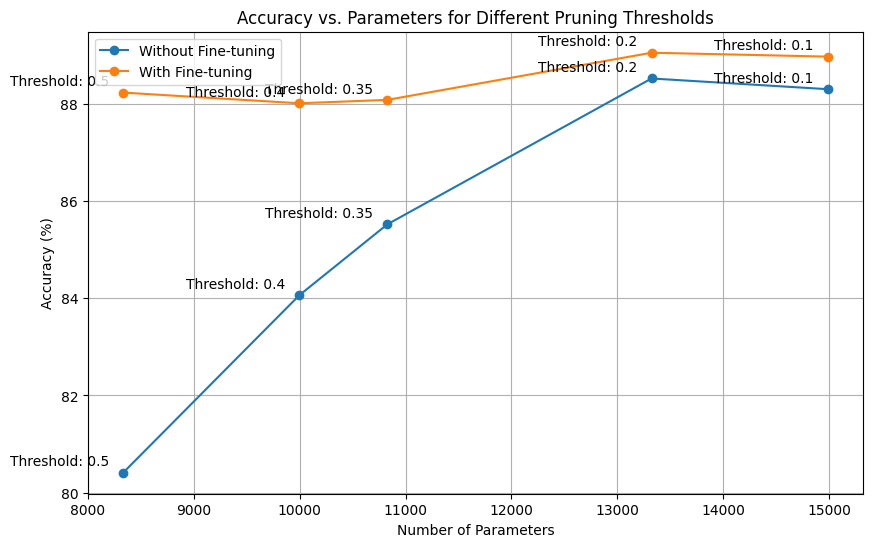

In [ ]:
thresholds = [0.1, 0.2, 0.35, 0.4, 0.5]
parameters = [14988, 13324, 10828, 9996, 8332]
acc_no_finetune = [88.3, 88.52, 85.52, 84.06, 80.41]
acc_finetune = [88.97, 89.05, 88.08, 88.01, 88.23]

# Plot accuracy vs. parameters with labels
plt.figure(figsize=(10, 6))
plt.plot(parameters, acc_no_finetune, marker='o', linestyle='-', label='Without Fine-tuning')
plt.plot(parameters, acc_finetune, marker='o', linestyle='-', label='With Fine-tuning')

for i, threshold in enumerate(thresholds):
    plt.annotate(f'Threshold: {threshold}', (parameters[i], acc_no_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')
    plt.annotate(f'Threshold: {threshold}', (parameters[i], acc_finetune[i]), textcoords="offset points", xytext=(-10, 5), ha='right')

plt.title('Accuracy vs. Parameters for Different Pruning Thresholds')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

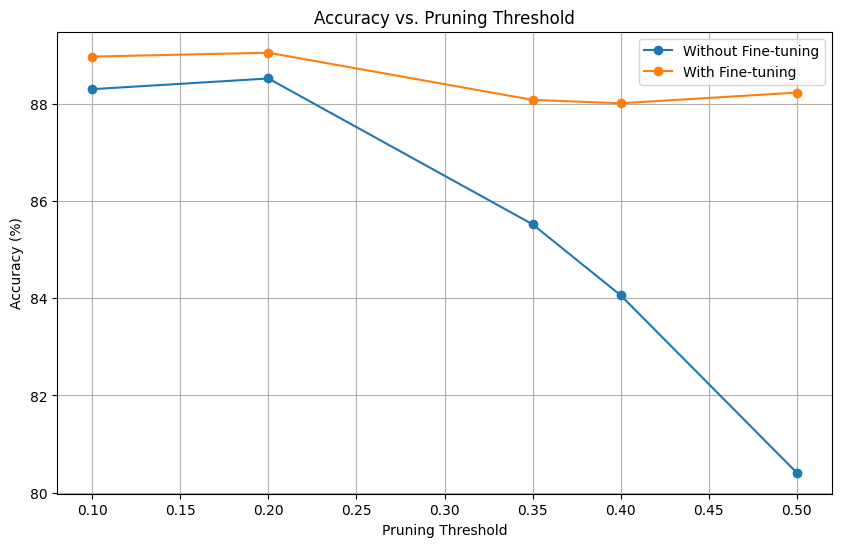

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, acc_no_finetune, marker='o', linestyle='-', label='Without Fine-tuning')
plt.plot(thresholds, acc_finetune, marker='o', linestyle='-', label='With Fine-tuning')
plt.title('Accuracy vs. Pruning Threshold')
plt.xlabel('Pruning Threshold')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()